In [2]:
from fastai.vision.all import *

df = pd.read_parquet("training_samples_iteration_1.parquet")
df


,filepath,label_name,confidence,predicted_label
0,data/imagenette/2/00346.jpg,cassette player,NaN,None
1,data/imagenette/2/00845.jpg,cassette player,NaN,None
2,data/imagenette/2/00383.jpg,cassette player,NaN,None
3,data/imagenette/2/00503.jpg,cassette player,NaN,None
4,data/imagenette/2/00002.jpg,cassette player,NaN,None
...,...,...,...,...
4543,data/imagenette/9/04543.jpg,parachute,0.121954,chain saw
7426,data/imagenette/8/07426.jpg,golf ball,0.122035,golf ball
2888,data/imagenette/4/02888.jpg,church,0.122096,French horn
7173,data/imagenette/8/07173.jpg,golf ball,0.122100,cassette player


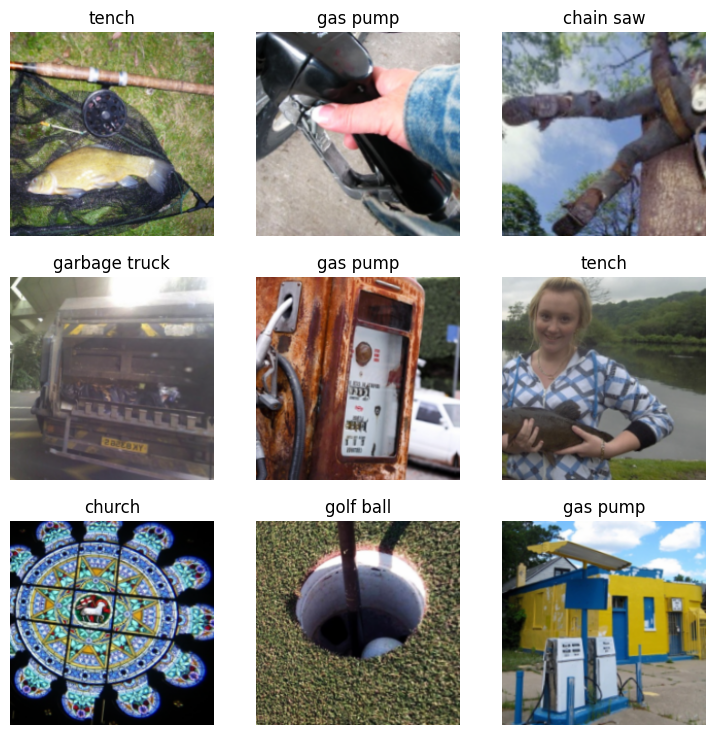

In [3]:
base_path = "."
dls = ImageDataLoaders.from_df(
    df,
    path=base_path,
    valid_pct=0.2,
    fn_col="filepath",
    label_col="label_name",
    bs=16,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=224, min_scale=0.75),
)

dls.show_batch()

/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, m

SuggestedLRs(valley=0.0010000000474974513, slide=0.001737800776027143)

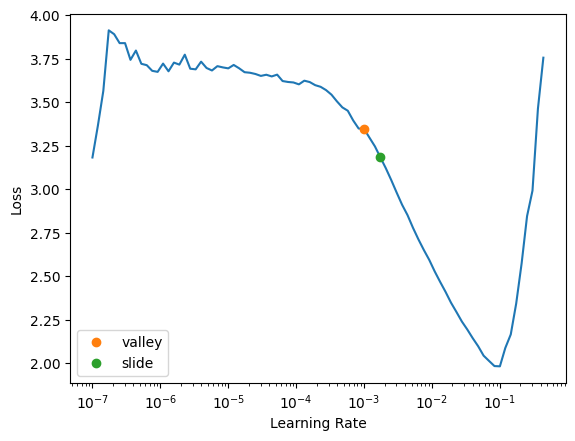

In [4]:
learn = vision_learner(dls, resnet18, metrics=accuracy).to_fp16()
learn.lr_find(suggest_funcs=(valley, slide))

epoch,train_loss,valid_loss,accuracy,time
0,3.349836,2.022405,0.400000,00:01


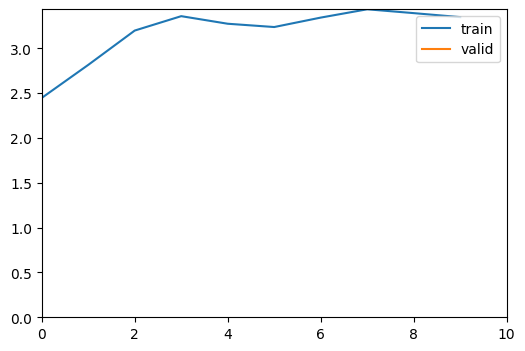

epoch,train_loss,valid_loss,accuracy,time
0,2.226786,1.600172,0.525000,00:01
1,2.017362,1.196020,0.750000,00:01
2,1.728764,0.891674,0.775000,00:01
3,1.359226,0.769815,0.775000,00:01
4,1.106045,0.707685,0.775000,00:01
5,0.926888,0.685284,0.775000,00:01
6,0.789953,0.678026,0.775000,00:01
7,0.674162,0.665015,0.775000,00:01
8,0.601232,0.640725,0.775000,00:01
9,0.517066,0.648461,0.775000,00:01


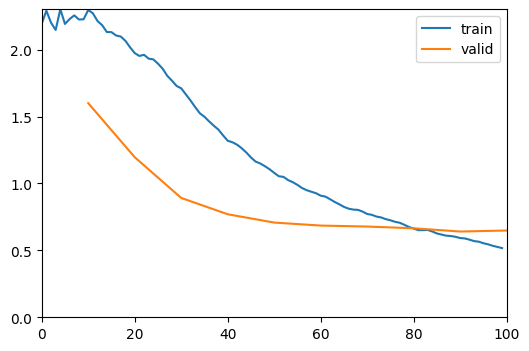

In [5]:
learn.fine_tune(10, 1e-3, cbs=[ShowGraphCallback()])

In [7]:
evaluation_samples = pd.read_parquet("evaluation_samples.parquet")
evaluation_samples



,filepath,label_name
0,data/imagenette/2/00000.jpg,cassette player
1,data/imagenette/2/00001.jpg,cassette player
2,data/imagenette/2/00002.jpg,cassette player
3,data/imagenette/2/00003.jpg,cassette player
4,data/imagenette/2/00004.jpg,cassette player
...,...,...
3920,data/imagenette/5/03920.jpg,French horn
3921,data/imagenette/5/03921.jpg,French horn
3922,data/imagenette/5/03922.jpg,French horn
3923,data/imagenette/5/03923.jpg,French horn


In [8]:
test_dl = dls.test_dl(evaluation_samples["filepath"].tolist())

preds = learn.get_preds(dl=test_dl, with_decoded=True)
preds


/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/home/dnth/Desktop/active-learning-flywheel/.venv/lib/python3.12/site-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


(tensor([[5.4368e-04, 5.4121e-05, 9.9410e-01,  ..., 2.5544e-04, 2.9253e-05,
          1.8167e-04],
         [1.6207e-03, 5.7441e-05, 9.9503e-01,  ..., 7.3325e-05, 2.8159e-05,
          5.0403e-04],
         [5.8493e-06, 6.3394e-05, 9.9963e-01,  ..., 2.1281e-05, 1.5557e-07,
          1.4112e-06],
         ...,
         [4.8688e-05, 9.9863e-01, 2.6705e-05,  ..., 4.1855e-04, 1.0855e-04,
          1.4919e-04],
         [2.1933e-08, 1.0000e+00, 5.5456e-09,  ..., 1.8297e-09, 2.6055e-09,
          2.7040e-09],
         [1.2552e-04, 9.9697e-01, 6.7814e-05,  ..., 2.3231e-05, 2.6397e-06,
          6.2351e-05]]),
 None,
 tensor([2, 2, 2,  ..., 1, 1, 1]))

In [9]:
# Convert tensor to numpy array for easier handling
pred_indices = preds[2].numpy()

# Map indices to class names using the vocabulary
pred_classes = [learn.dls.vocab[idx] for idx in pred_indices]

pred_classes


['cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'gas pump',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'cassette player',
 'casse

In [10]:
evaluation_samples['predicted_label'] = pred_classes
evaluation_samples

,filepath,label_name,predicted_label
0,data/imagenette/2/00000.jpg,cassette player,cassette player
1,data/imagenette/2/00001.jpg,cassette player,cassette player
2,data/imagenette/2/00002.jpg,cassette player,cassette player
3,data/imagenette/2/00003.jpg,cassette player,cassette player
4,data/imagenette/2/00004.jpg,cassette player,cassette player
...,...,...,...
3920,data/imagenette/5/03920.jpg,French horn,French horn
3921,data/imagenette/5/03921.jpg,French horn,French horn
3922,data/imagenette/5/03922.jpg,French horn,French horn
3923,data/imagenette/5/03923.jpg,French horn,French horn


In [12]:
accuracy = (evaluation_samples['label_name'] == evaluation_samples['predicted_label']).mean()
print(f"Overall Accuracy: {accuracy:.2%}")


Overall Accuracy: 94.57%
